!["Intro"](assets/intro_banner.png)


We now continue our journey diving deeper into the dynamics of single and multiple atom systems.

### Learning Objectives

#### By the end of the session, you will be able to:
- Describe the Rydberg bloqade phenomenon
- Compute the dynamics of multi-qubit Rydberg systems describing the effects of the blockade on Rabi oscillations
- Analyze Rydberg phases on square lattices

## 1. Intro to Rydberg dynamics


Now that we have learned all the basic control parameters for neutral-atom analog quantum computers, we can start looking at running programs and studying interesting dynamics for problem solving. This is the theme of this chapter.

### 1a. Dynamics for a single atom

In this section we will look more formally at the effect of the Rabi drive on a single atom, and then multiple atoms. 

We saw in Chapter I that we control this Rabi drive with the Rabi waveform $\Omega (t)$. If $\phi = 0$, and $\Delta = 0$, and we only have one atom, then the Hamiltonian of the problem simplifies to just:

$$
H = \frac{\Omega(t)}{2} \left(|g\rangle\langle r| +|r\rangle\langle g|\right) \equiv \frac{\Omega(t)}{2} \sigma_x
$$

where we represent the state flipping operator as $\sigma_x \equiv \left(|g\rangle\langle r| +|r\rangle\langle g|\right)$, i.e., using the corresponding real-valued Pauli matrix.

### 1b. Rabi oscillations

**Rabi oscillations** is a canonical phenomenon in quantum dynamics. Given a single two-level system - aka, a qubit - started in the $|0\rangle$ of the computational '$z$-basis', and a driving field around an axis not parallel with this $z$, we observe oscillations in the qubit state. 

Here is a diagram with the corresponding mathematical solutions:

<img src="assets/Rabi_diagram.png" width="500" height="auto" />

The simplest scenario occurs in the presence of a constant field in a direction perpendicular to $z$, say $x$ as in the figure above. As time $t$ advances, the state of our qubit would oscillate sinusoidially between
the initial state $|g\rangle$ and the excited state $|r\rangle$. 

For neutral-atom systems, this oscillation can be easily verified by measuring a $z$-observable such as the occupation of the Rydberg state:

$$
<\hat{n}> = \langle \psi (t) | \hat{n} | \psi (t) \rangle = \sin^2 \frac{\Omega}{2}t
$$

where $ \hat{n} = 1 * |r \rangle \langle r | + 0 * | g \rangle \langle g |$ and the state $|\psi \rangle$ is as in the figure above. The result of such evolution can be depicted as in the figure below.


<img src="assets/Rabi_oscillation.png" width="500" height="auto" />

#### Example: Single atom dynamics

Let's work through how to deploy this single atom example on Bloqade

In [1]:
from bloqade import start, cast, load, save
import os
import matplotlib.pyplot as plt
from bokeh.io import output_notebook
from bloqade.atom_arrangement import ListOfLocations
from bloqade import  piecewise_linear, cast
import numpy as np
output_notebook()

if not os.path.isdir("data"):
    os.mkdir("data")

Loading BokehJS ...

We will need a single atom

In [2]:
atom_coordinate=ListOfLocations([(0,0)])
atom_coordinate.show()

And a simple Rabi waveform, as flat as possible

In [3]:
ramp_time=0.06
rabi_ampl=15
detuning_value=0.0
run_time=1.0

durations = [ramp_time, run_time, ramp_time]
values=[0, rabi_ampl, rabi_ampl, 0]
waveform_rabi = piecewise_linear(durations, values)
waveform_rabi.show()

> note: our quantum hardware constraints demand that the wave form for the Rabi amplitude requires ramping up and down from zero at the ends of the protocol. The Rabi oscillations result above is still valid for this time-dependent protocol, except that the accumulated phase $\Omega t$ as function of time must be exchanged for the integrated frequency amplitude $\int_0^t d\tau \Omega(\tau)$. We leave proving this as an exercise to the reader.

Now it is time to learn some more Bloqade tricks. We want to evolve our quantum state under the same Hamiltonian for multiple times of different durations, in order to visualize the state's time evolution. Running via `rydberg_h()` like last chapter is possible, but cumbersome. Here we will learn how to batch tasks and use variables to streamline our workflow.

While `rydberg_h()` operated simply by ingesting a register made of  a `ListOfPositions` and `piecewise_linear` and `piecewise_constant` waveforms, we will now take a different path that will require generating a program and including atom and waevform objects in a concatenated way. Here is how it goes.

We beging by using the `start` object to create our `register`. Then we concatenate a register using a `.` syntax and the `add_position` method:

In [4]:
register1 = ( start.add_position((0, 0)))

Now we continue concatenating waveform instructions to create a full `rabi_oscillations_program`. First, we include a control for a uniformly distributed (independent of atom index, as in the actual hardware) Rabi amplitude:  

In [6]:
durations = cast(["ramp_time", "run_time", "ramp_time"])

register_rabi = (
    register1
    .rydberg.rabi.amplitude.uniform.piecewise_linear(durations=durations, values=[0, "rabi_ampl", "rabi_ampl", 0])
)

Note we are using here our old `piecewise_linear` method, but taking the opportunity to include variables `"ramp_time"`, `"run_time"`, and `"rabi_ampl"` which are not predetermined before we start running the program. This makes the program really a "function", which can be automatically called for different values of ramp times, running times, and strengths of the Rabi amplitude!

For the sake of completeness, we can complete the `rabi_oscillations_program` with a uniform (instead of locally varying) constant detuning $\Delta$ field

In [7]:
rabi_oscillations_program = (
    register_rabi
    .detuning.uniform.constant(duration=sum(durations), value="detuning_value")
)

Of course, you could perform this full concatenation in a single strike, which may be easier once you get used to the syntax:

In [8]:
durations = cast(["ramp_time", "run_time", "ramp_time"])

rabi_oscillations_program = (
    start.add_position((0, 0))
    .rydberg.rabi.amplitude.uniform.piecewise_linear(durations=durations, values=[0, "rabi_ampl", "rabi_ampl", 0])
    .detuning.uniform.constant(duration=sum(durations), value="detuning_value")
)

Now we are ready to run. We create a list `run_times` of 101 time instances at which we want to evaluate the time evolution of our qubit within $3 \mu s$, assign specific values for variables with a unique desired value such as "ramp_time", `"rabi_ampl"` and `"detuning_value"`, and `batch_assign` the `"run_time"` lengths from our list `run_times`.

This will create a `rabi_oscillation_job`, that will contain tasks with different time evolutions as one batch.  

In [13]:
run_times = np.linspace(0, 3, 101)

ramp_time=0.06
rabi_ampl=15
detuning_value=0.0

rabi_oscillation_job = rabi_oscillations_program.assign(
    ramp_time=ramp_time, rabi_ampl=rabi_ampl, detuning_value=detuning_value
).batch_assign(run_time=run_times)

Again, while this looks more evolved than a simple `rydberg_h`, the flexibility and conciseness for running multiple tasks at once more than compensates for that!

We are almost ready submit this batch job to the emulator, specifying the number of times each task (i.e., each time step) is measured. Usually we call this the number of "shots" for a given task. In this case we use 100. The more shots we have, the better accuracy in our measurements (usually this measurement accuracy goes as $1/\sqrt{N}$ where $N$ is the chosen number of shots). If we pick too few, will not be able to plot the evolution properly.

One last subtletly: because we will have multiple measurement data, it is good practice to save and collect that information in specific data files. Here is how we do all of this:

In [11]:
emu_filename = os.path.join(os.path.abspath(""), "data", "rabi-emulation.json")

if not os.path.isfile(emu_filename):
    emu_batch = rabi_oscillation_job.braket.local_emulator().run(100)
    save(emu_batch, emu_filename)

We wrap this process with a quick plotting script that loads the data, averages the different shot outcomes for each oscillation point, and joins all results as function of time in a plot

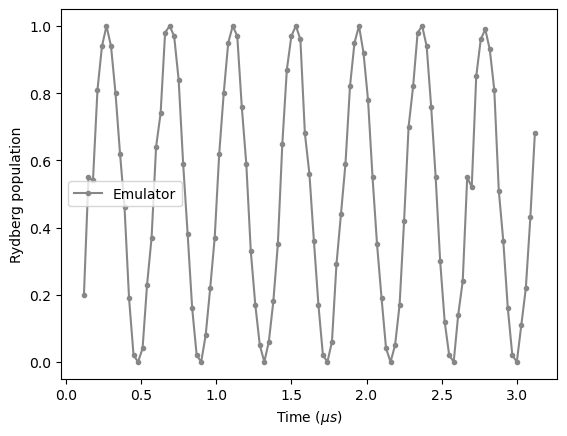

In [14]:
emu_batch = load(emu_filename)

#hardware_report = hardware_batch.report()
emulator_report = emu_batch.report()

times = emulator_report.list_param("run_time")
for i in range (len(times)):
    times[i]=times[i]+ 2*ramp_time
density = [1 - ele.mean() for ele in emulator_report.bitstrings()]
plt.plot(times, density, color="#878787", marker=".", label="Emulator")

plt.xlabel("Time ($\mu s$)")
plt.ylabel("Rydberg occupation")
plt.legend()
plt.show()

Rabi oscillations! The finer we probe the time axis and the more statistics we build with higher shot counts, the closer to a sine this figure will be. But above everything, the program above can be readily deployed in actual quantum hardware so you can consider testing our qubit callibrations by yourself!

## 2. Few-qubit dynamics

Qubits in isolation don't do much. We want to get more of them together, and we want to entangle them. To do so, let's start with a quick recap of the Hamiltonian describing the dynamics of several atoms, which we will index by $i$. 

Dynamics are controlled, generally, but the **Rabi amplitude** terms, which may or may not include a phase $\phi$, and act individually (but uniformly) on each atom according to

$$
 \sum_i \frac{\Omega(t)}{2} \left( e^{i \phi(t) } | g_i \rangle  \langle r_i | + e^{-i \phi(t) } | r_i \rangle  \langle g_i | \right).
$$

The **deturning** term $\Delta$ represents how off-resonant the laser is from the atomic energy transition and incurr an energy cost (positive or negative) for excitations into the Rydberg state:

$$
\sum_i \Delta(t) \hat{n}_i,
$$

where

$\hat{n}_i= 0|g_i \rangle  \langle g_i | + 1| r_i \rangle  \langle r_i |. $  


Finally, when multiple atoms are excited to a Rydberg state, they are subject to Van der Waals interactions, which is captured by the term
$$
\sum_{i < j} V_{ij} \hat{n}_i \hat{n}_j
$$

where $V_{ij}$ is given by
$$
V_{ij} = \frac{C_6}{|x_i - x_j|^6}.
$$

Here $C_6 = 862,690 MHz \mu m^6 $ is the Rydberg interaction coefficient.

Bringing it all together, we obtain

$$
\frac{\mathcal{H}(t)}{\hbar} = \sum_i \frac{\Omega(t)}{2} \left( e^{i \phi(t) } | g_i \rangle  \langle r_i | + e^{-i \phi(t) } | r_i \rangle  \langle g_i | \right) - \sum_i \Delta(t) \hat{n}_i + \sum_{i < j} V_{ij} \hat{n}_i \hat{n}_j,
$$
as in the previous chapter.

### 2a. Rydberg blockade phenomenon

When neutral-atom qubits are brought into contact, they may interact and entangle. The physical processes by which this can be controlled is characterized by the last term in the Hamiltonian above, the 2-qubit interaction energy $V_{ij}$.

The key observation is that when an atom is “puffed-up” to a **Rydberg state**, it is capable of a strongly shifting the energies of the states of adjacent atoms, conditional on them being also excited to Rydberg levels. In other words, if two atoms "$i$" and "$j$" are close together (on a length scale of order 𝜇𝑚), they interact through a state-dependent energy shift. If noneo or only one atom is in the Rydberg state, there is no energy shift as $\hat{n}_i \hat{n}_j=0$. If both atoms are in the Rydberg state, however, the energy of that state is further shifted by $V_{ij}$. If this shift is large enough, the state with double excitation is effectively expelled from the Hilbert space: no combination of $\Omega$ and $\Delta$ will enable us to access it! This phenomenon is known as the **Rydberg blockade**, as an atom excited to a Rydberg state blocks its neighbors from exciting as well.

> it is crucial to appreciate: the Rydberg blockade phenomnenon can **digitize** the conditional dynamics. Once atoms get close enough, they are **always** blocked no matter the details of how close they get. Because the $1/r_{ij}^6$ power law decays extremely fast, once atoms are far away, they are **always** independent. **No fine tuning is necessary**, but, of course, how one leverages these interactions for generating complex quantum dynamics can be quite subtle.  

But how close is "close enough"? How can we observe this Rydberg blockade phenomenon? And how can we use it for solving interesting problems with our quantum computer? 

Answering these questions is the topic of this section!

### 2b. The Rydberg blockade radius

Let's start by quantifying our sense of how much "close" is "too close", i.e., what is the characteristic distance at which the Rydberg blockade mechanism sets in.

For this, consider a problem of two atoms in the presence of a Rabi oscillation field. The Hamiltonian for this problem can be written

$$
H_{12}= \frac{\Omega}{2} \left( |g_1 \rangle \langle r_1| + |g_2 \rangle \langle r_2| + H.c.\right) +V_{12}\hat{n}_1\hat{n}_2
$$



<img style="float: right;" src="./assets/pic2-13.png" width="350" height="auto" />


If the atoms are a distance $d$ apart, $𝑉_{12}=C_6/d^6$.

To set up the scale for blockading interactions, we need to think a bit like physicists. We ought to appreciate that $𝑉_{12}$ is a power-law, and does not have a natural scale for large or small $d$. Yet, the blockading phenomenon is always a function of our capacity to generate excitations into the $|r_1 r_2 \rangle$ state. While the enegy of that state depends on the distance between the atoms, if $\Omega$ is large enough, in fact, it is always possible to generate excitations into it. Converselly, for a fixed Rabi amplitude, there is always a distance small enough beyond which we cannot access the doubly excited state any more.

So all we have to do is to compare $𝑉_{12}$ with $\Omega$ to set that characteristic distance. Equating $𝑉_{12}=\Omega$, we can solve for said corresponding distance, which we name $R_B$, obtaining

$$
R_B= (C_6⁡/\Omega)^{1/6}.
$$

A clear interpretation of this can be obtained by looking at the spectrum of $H_{12}$, first in the absence of $\Omega$, and then in a "hypothetical" absence of $V_{12}$. We reproduce this spectrum as function of $d$ in the figure above. The  $y$-axis corresponds to energy and black dashes at $d=0$ mark the spectrum in the absence of $V_{12}$. The red curves, conversely, correspond to the energy levels in the absence of $\Omega$, when only $V_{12}$ is present. The red curve that bends up is the energy of the $|r_1 r_2 \rangle$ state. The blockade radius marks the crossing between $\Omega$, and $V_{12}$. Atoms at any distance smaller than at this crossing simply cannot be excited by the Rabi amplitude.

> Note that the argument above works when only one dynamic energy scale exists, $\Omega$. When detuning values are present, a similar argument applies but, in this case, first one has to combine $\Omega$ and $\Delta$ into the true dynamical energy scale of the qubits. In this case, the blockade radius formula generalizes to
> $$
> R_𝒃 = [\frac{C_6}{⁡{\sqrt{\Omega^2 + \Delta^2}⁡}}]^{1/6}
> $$

#### Example: Two-atom dynamics

Now lets run through an example of two atoms.  This will allow us to observe the effect of Rydberg Blockade. In this example, $\Delta =0$.

First lets define a function to plot the lattice with Rydberg Radius.  This will come in handy later when we start using Detuning frequencies.

In [31]:
def plot_lattice_Rb(atom_coordinate, Rb):

    def within_Rb(i,j):
        dist=((x[i]-x[j])**2 + (y[i]-y[j])**2)**0.5
        if dist < Rb:
            return (True)
        else:
            return (False)
        
    import matplotlib.pyplot as plt
    x=[]
    y=[]
    index=1
    for i,j in atom_coordinate: 
        x.append(i), y.append(j)
        plt.text(i,j,index,bbox={"boxstyle" : "circle"})
        index+=1


        
    # Draw Rb edges
    for i in range(len(x)):
        for j in range(len(x)):
            if i<j:
                if within_Rb(i,j):
                    plt.plot([x[i],x[j]], [y[i],y[j]], 'k-')

    plt.xlim(0,max(x)+1)
    plt.ylim(0,max(y)+1)
    plt.axis('equal')
    plt.xlabel('\u00B5m')
    plt.ylabel('\u00B5m')
    plt.scatter(x,y)
    plt.show()

We also define a general function that can take in any atom geometry and plot the Rydberg densities for the combination of atoms with time.

In [38]:
def many_body_dynamics(atom_coord, max_omega, max_delta, max_run_time):

    run_times = np.linspace(0, max_run_time-0.2, 61)
    
    n_atom=len(atom_coord)
    print("Number of Atoms: ",n_atom)
    
    C6 = 2*np.pi * 862690;
    if max_delta>0 or max_omega>0:
        Rb = (C6 / ((max_delta**2 + max_omega**2)**(1/2))) ** (1/6)
        print("Rydberg Radius: ",Rb)
    else:
        Rb=0
        print("Rb undefined")

    plot_lattice_Rb(atom_coord, Rb)
    
    program = (
        start.add_position(atom_coord)
        .rydberg.detuning.uniform.
        piecewise_linear(
            durations = [0.1, "run_time", 0.1],
            values = [-max_delta, -max_delta, max_delta, max_delta]
        )
        .amplitude.uniform.
        piecewise_linear(
            durations = [0.1, "run_time", 0.1],
            values = [0, max_omega, max_omega, 0]
        )
        .batch_assign(run_time=run_times)
    )
    
    emulator_batch = program.braket.local_emulator().run(5000)
    
    emulator_report=emulator_batch.report()
    times = emulator_report.list_param("run_time")
    for i in range (len(times)):
        times[i]=times[i]+ 0.2
    density = [n_atom - n_atom*ele.mean() for ele in emulator_report.bitstrings()]
    plt.plot(times, density, color="#878787", marker=".", label="Emulator")
    
    plt.xlabel("Time ($\mu s$)")
    plt.ylabel("Rydberg population")
    plt.legend()
    plt.show()

#### i) Atoms far apart

First lets start with two atoms considerably far apart so they do not interact with each other.

In [33]:
atom_coord=[(0, 0), (0,20)]

In [34]:
max_delta=0
max_omega = 2*np.pi*2
max_run_time = 2.0

We can verify the Rydberg Radius and see it is much smaller than the distance between the atoms

In [35]:
C6 = 2*np.pi * 862690;

Rb = (C6 / max_omega) ** (1/6)
print("Rydberg Radius: ",Rb)

Rydberg Radius:  8.692355131311515


Lets plot the atoms with the following function, which draws an edge between atoms if the atoms are within the Rydberg Radius

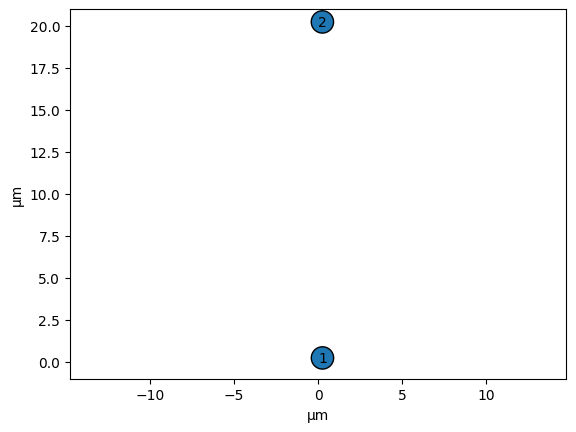

In [36]:
plot_lattice_Rb(atom_coord, Rb)

Now we can run the many body dynamics function which will show the rabi frequency dynamics

Number of Atoms:  2
Rydberg Radius:  8.692355131311515


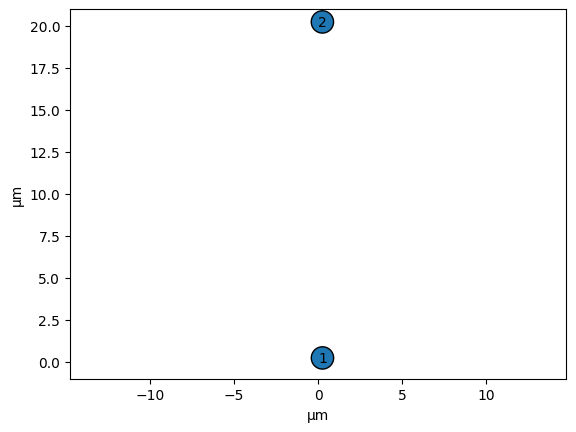

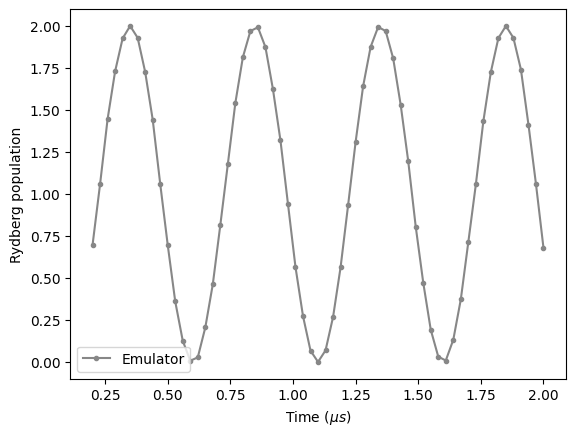

In [39]:
many_body_dynamics(atom_coord, max_omega, max_delta, max_run_time)

Notice that the atoms are far apart enough that they did not have any additional interaction and thus each atom reached the Rydberg state, thus a maximum amplitude of 2.

#### ii) Atoms closer together

Now we bring the two atoms close together so we see the effect of the Rydberg blocade.  $\Delta =0$.

In [40]:
atom_coord=[(0, 0), (0,6)]
max_delta=0
max_omega = 2*np.pi*2
max_run_time = 2.0

We calculate the Rydberg radius

In [41]:
C6 = 2*np.pi * 862690;

Rb = (C6 / max_omega) ** (1/6)
print("Rydberg Radius: ",Rb)

Rydberg Radius:  8.692355131311515


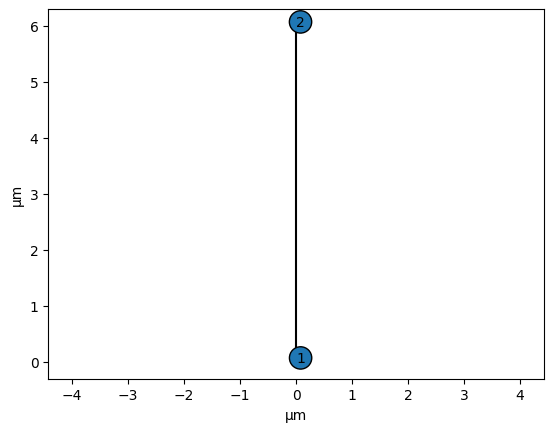

In [42]:
plot_lattice_Rb(atom_coord, Rb)

This time you can see there is an edge between the two atoms, indicating the atoms are within the Rydberg radius.

Number of Atoms:  2
Rydberg Radius:  8.692355131311515


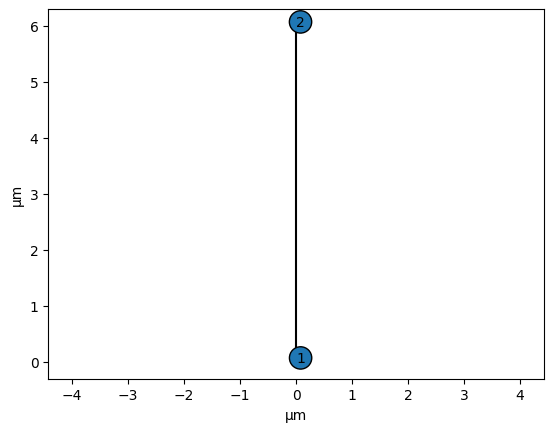

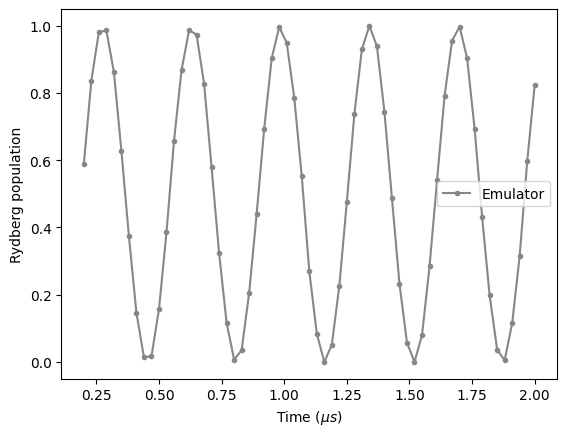

In [43]:
many_body_dynamics(atom_coord, max_omega, max_delta, max_run_time)

Notice that due to the extra energy needed from the interaction, only one atom is able to reach the Rydberg state. This in effect is the Rydberg blockade.  The total Rydberg density due to the closeness of the atoms and their interaction is only able to reach a maximum amplitude of 1.0. 

#### Example: 3 atoms in a chain 

We will look at the results of the Many-body Rabi oscillations for three atoms in a chain. 


#### i) Atoms far apart

In the first example, the separation is substantial at 20 $\mu m$. None of th atoms interact with each other, and each is able to reach the Rydberg state. Thus the total Rydberg density of the system reaches 3.0

Number of Atoms:  3
Rydberg Radius:  8.692355131311515


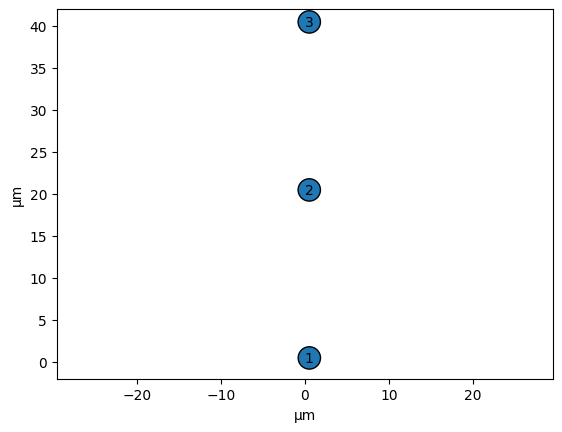

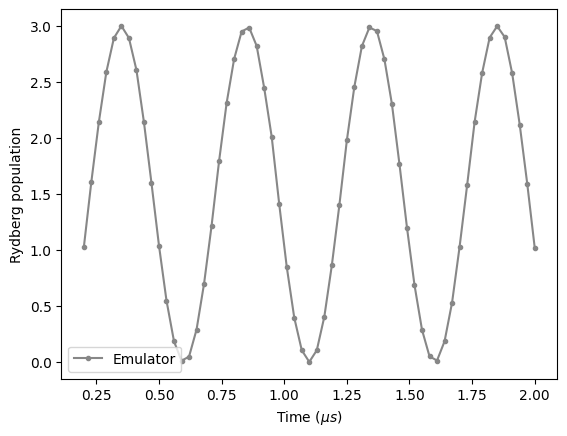

In [44]:
atom_coord=[(0, 0), (0,20), (0,40)]
max_delta=0
max_omega = 2*np.pi*2
max_run_time = 2.0
many_body_dynamics(atom_coord, max_omega, max_delta, max_run_time)

#### ii) Atoms close together

In the second example the atoms are closer together at 6 $\mu m$ and show interaction beween the atoms.  Notice there is a Rydberg Blockade effect which is preventing all atoms from reaching the Rydberg state together thus the maximum Rydberg density is less than 1.6.

Number of Atoms:  3
Rydberg Radius:  8.692355131311515


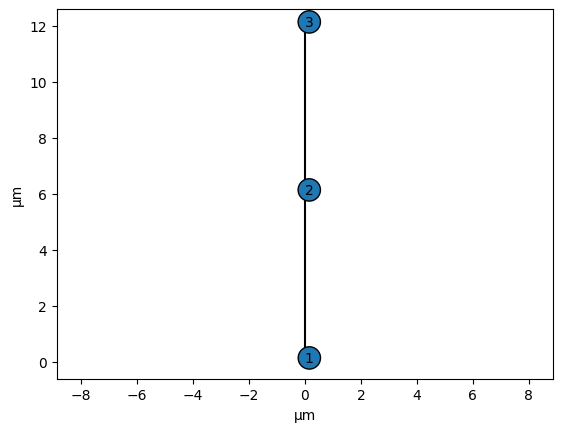

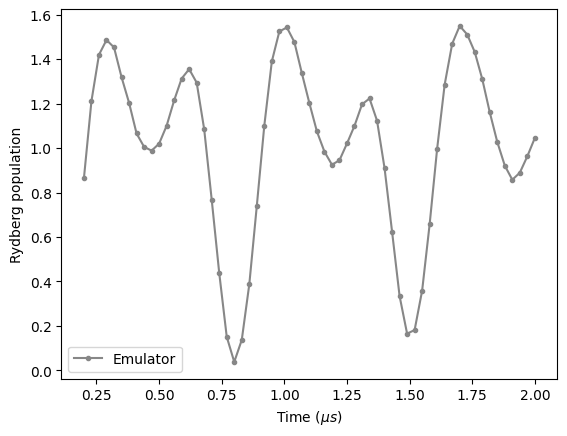

In [45]:
atom_coord=[(0, 0), (0,6), (0,12)]
max_delta=0
max_omega = 2*np.pi*2
max_run_time = 2.0
many_body_dynamics(atom_coord, max_omega, max_delta, max_run_time)

In the results above the effect of the interaction of multiple atoms is evident. The atoms interaction leads to a maximum Rydberg density less than 1.6. 

* Problem: Try different atom configurations and evaluate the effect on the Rydberg Density.

#### Example: 3 atoms in a triangle 

We now repeat the experiment for an equilateral triangle, where the distance between each of the atoms with the other atom is the same. This is a special condition, and will reveal some interesting results.

#### i) atoms far apart

Number of Atoms:  3
Rydberg Radius:  8.692355131311515


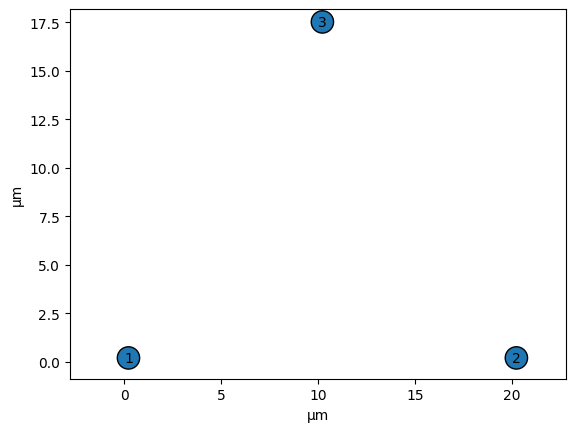

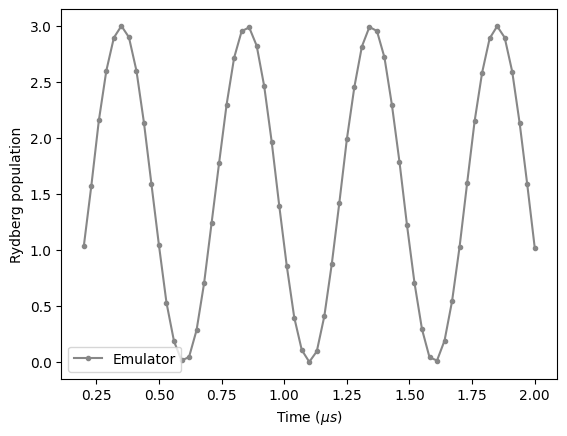

In [46]:
atom_coord=[ (0.0, 0.0),  (20.0, 0.0),  (10.0, 17.3205)]
max_delta=0
max_omega = 2*np.pi*2
max_run_time = 2.0
many_body_dynamics(atom_coord, max_omega, max_delta, max_run_time)

#### ii) atoms close together

Number of Atoms:  3
Rydberg Radius:  8.692355131311515


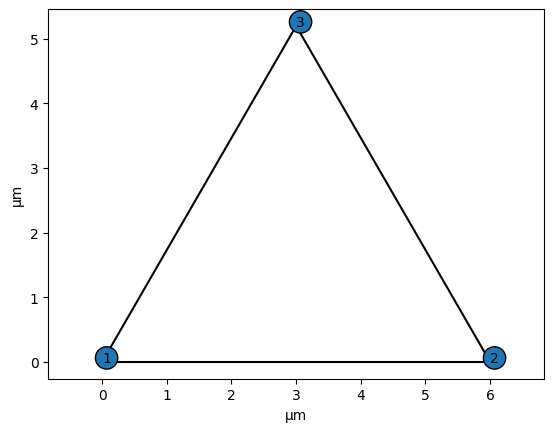

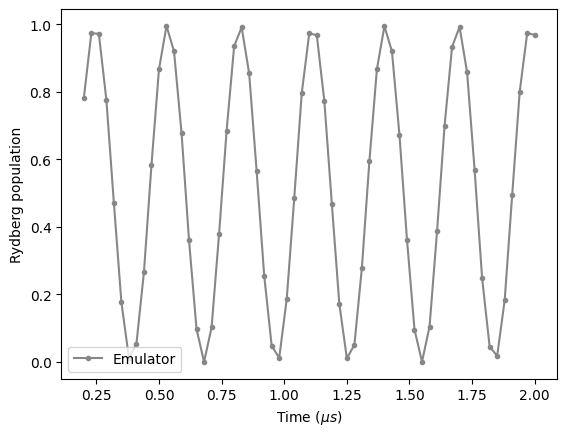

In [48]:
atom_coord=[(0.0, 0.0), (6.0, 0.0), (3.0, 5.196152422706632)]
max_delta=0
max_omega = 2*np.pi*2
max_run_time = 2.0
many_body_dynamics(atom_coord, max_omega, max_delta, max_run_time)

Notice the above three atoms are equidistant and thus they interact equally, causing all three to become one single Rydberg state. Thus the maximum amplitude of the Rydberg density is 1. 

### Activity: Find excitation patterns

In the activity below, which atoms will be excited to the Rydberg state in the followoing two scenarios:

a) Rydberg Radius extends to the first neighbors (red) $R_{B,a}

b) Rydberg Radius extends to the diagonal neighbors (cyan) $R_{B,b}

Identify if there are different possibilities for each scenario

!["Excitation paterns"](assets/pic2-11.png)

## 3. Many-body Ordered phases

Now we see examples with few-atom interactions. This example
extends to the case with many interacting atoms, for up to 256
qubits. Typically, the dynamics and quantum behavior of these
systems extend well beyond the computational power of classical
emulation, which typically requires exponential resources in the
number of qubits ($2^{256}$). In this example, instead of studying
quantum dynamics, we focus on the physics of blockade effect on
the quantum many-body ground states by preparing ordered
phases of the 1D chain and 2D square lattice. The associated
Jupyter notebook is provided here.
As we understand from previous examples, an intuitive understanding of the blockade effect on the ground state is
as follows: With a positive detuning Δ, adding Rydberg excitations lowers the ground state energy. However, the
Rydberg excitations are subject to the Rydberg blockade effect—a large positive energy penalty which enforces that
only one Rydberg excitation is allowed within the blockade radius. The interplay of these two mechanisms allows
the creation of different ordered states (and more exotic states) depending on the strength of the blockade radius
and the detuning. Let us start with the 1D chain for simplicity: if the blockade radius encompasses nearest
neighbors, the many-body ground state is an alternating pattern of ground and Rydberg state, called a $𝑍_2$ state. If the
blockade radius contains next-nearest neighbors, the many-body ground state is alternating ground-groundRydberg, or $𝑍_3$; and so on

### 3a. The 1D $Z_2$ phase 

We use an adiabatic evolution to prepare the simplest quantum many-body ground state, the 1D $Z_2$ state. To do that,
we can start with all atoms in the ground state ∣0⟩, which is the ground state of the many-body Hamiltonian with a
large negative detuning Δ. Then, the Rabi frequency Ω is turned on, and the detuning strength is ramped up from a
large negative value to positive values. If such a process is slow enough, the quantum state of the system stays close
to the ground state of the time-dependent Hamiltonian at time 𝑡 by the adiabatic theorem. At the end of this process, we arrive at a target Hamiltonian, and correspondingly, the prepared state is the ground state of the final
Hamiltonian.

In [49]:
Chain(11, lattice_spacing=5.3).show()

In [50]:
# Change the lattice spacing to vary the atom separation a
delta_end=2*np.pi*5
omega_max=2*np.pi*2.5

C = 11
lattice_spacing=5.3

C6 = 2*np.pi * 862690 
Rb = (C6 / ((max_delta**2 + max_omega**2)**(1/2))) ** (1/6)
print("Rb/a: ",Rb/lattice_spacing)


print("Delta/Omega: ", delta_end/omega_max)

Rb/a:  1.6400670059078333
Delta/Omega:  2.0


In [51]:
rabi_amplitude_values = [0.0, omega_max, omega_max, 0.0]
rabi_detuning_values = [-20, -20, "delta_end", "delta_end"]
durations = [0.2, "sweep_time", 0.2]

prog = (
    Chain(C, lattice_spacing=lattice_spacing)
    .rydberg.rabi.amplitude.uniform.piecewise_linear(durations, rabi_amplitude_values)
    .detuning.uniform.piecewise_linear(durations, rabi_detuning_values)
)

batch = prog.assign(delta_end=delta_end, sweep_time=3.6)

In [52]:
emu_batch=batch.bloqade.python().run(shots=100)

In [53]:
emu_batch.report().show()

In the above ground state result, the next most probable bitstrings all have a single excitation missing.

In [82]:
### This is an alternative way to run the above using Amazon Braket local emulator. It will take a few minutes to run

#emu_batch=batch.braket.local_emulator().run(shots=100)
#emu_batch.report().show()

### 3b. The 2D striated and checkerboard phase

!["Ordered phases"](assets/pic2-12.png)

When we go beyond a few atoms and have a large number of atoms, classically, it will require exponental computational resources to determine the quantum dynamics. However we can study the general effect for different range of parameters $\frac{R_b}{a}$ and $\frac{\Delta}{\Omega}$ as shown in the diagram above.

Keeping $\frac{\Delta}{\Omega}$ constant at $2.7$, if we increase the value of  $\frac{R_b}{a}$ (i.e. we are increasing the Rydberg radius compared to the separation of the atoms), we notice a checkerboard pattern at 1.2, while at around 1.7 we see a star pattern. 

At low values of $\frac{\Delta}{\Omega}$ we have disorderd states, and at the transitions we get Striated, Rhombic and Banded patterns.

### Example: checkerboard pattern

In the example below, you can vary the lattice spacing which change the value of the atom separation, $a$. THe values of Rb/a and Delta/Omega are printed, to show the location on the chart above. After running the simulation with the reduced number of atoms, we can get an idea of the effect of the Rydberg blockade on the lattice pattern.

In [69]:
# Change the lattice spacing to vary the atom separation a, and thus also Rb/a
delta_end=42.66
omega_max=15.8
sweep_time = 2.4
lattice_spacing = 7
L=3

C6 = 2*np.pi * 862690;
Rb = (C6 / ((delta_end**2 + omega_max**2)**(1/2))) ** (1/6)
print("Rb/a: ",Rb/lattice_spacing)


print("Delta/Omega: ", delta_end/omega_max)

Rb/a:  1.002117562367345
Delta/Omega:  2.6999999999999997


In [70]:
rabi_amplitude_values = [0.0, omega_max, omega_max, 0.0]
rabi_detuning_values = [-delta_end, -delta_end, delta_end, delta_end]
durations = [0.8, sweep_time, 0.8]

prog = (
    Square(L, lattice_spacing=lattice_spacing)
    .rydberg.rabi.amplitude.uniform.piecewise_linear(durations, rabi_amplitude_values)
    .detuning.uniform.piecewise_linear(durations, rabi_detuning_values)
)


In [71]:
emu_prog=prog.bloqade.python().run(shots=100)
emu_prog.report().show()

In [72]:
### This will take a few minutes to run

emu_prog=prog.braket.local_emulator().run(shots=10000)
emu_prog.report().show()


* Problem: In the above results, click on the counts bar and validate the pattern in the middle plot.  Do the results make sense based on the Rydberg Radius?  Try changing the value of the lattice spacing to look at different checkerboard patterns, and even try to create a star or staggered pattern.